In [ ]:
!pip install -qU langgraph langchain tavily-python langchain_openai langchain_community

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'

# Tree of Thoughts

**Tree of Thoughts (ToT)** is a general LLM agent search algorithm that combines reflection/evaluation and simple search (in this case BFS).

It has three main steps:
1. **Expand**: generate 1 or more candidate solutions to the problem.
2. **Score**: measure the quality of the responses.
3. **Prune**: retain the top K best candidates.

Then return to "Expand" if no solution is found (or if the solution is of insufficient quality).

# Task Definition

In this section, our agent will try to play the "Game of 24". Given 4 numbers, it must generate a math equation that uses each of these numbers exactly one time to evaluate to a value of `24`.

In [1]:
import operator
from typing import List, Literal, Union, NamedTuple, Optional
from pydantic import BaseModel, Field


OperatorType = Literal['+', '-', '*', '/']
TokenType = Union[float, OperatorType]

# We use these schemas to prompt the LLM to generate equations that evaluate to 24.
class Equation(BaseModel):
    """The formula combining the provided numbers to reach the target of 24"""

    tokens: List[TokenType] = Field(
        description="""The stack of tokens and operators in reverse-polish notation.
        Example: [3, 4, '+', -1, '*'] would evaluate to (3 + 4) * -1 = -7.""",
    )

    def compute(self) -> float:
        op_funcs = {
            '+': operator.add,
            '-': operator.sub,
            '*': operator.mul,
            '/': operator.truediv,
        }

        stack = []
        for token in self.tokens:
            if isinstance(token, float):
                stack.append(token)
            else:
                b, a = stack.pop(), stack.pop()
                stack.append(op_funcs[token](a, b))

        return stack[0]



class GuessEquations(BaseModel):
    """Submit multiple equations as guesses"""

    reasoning: str = Field(
        description="The reasoning behind the submitted guesses. Explain how you arrived at these equations."
    )

    equations: List[Equation] = Field(
        description='The list of equations to submit as guesses.'
    )



# These objects will represent a single "candidate" (or scored candidate) within our agent's state.
# We can also update the candidate object toward other tasks
class Candidate(NamedTuple):
    candidate: Equation
    score: Optional[float] = None
    feedback: Optional[str] = None

    def __str__(self):
        try:
            computed = self.candidate.compute()
        except Exception as e:
            computed = f"Invalid equation: {self.candidate.tokens}; Error: {repr(e)}"

        return f"Equation({self.candidate.tokens}) = {computed} (Reward: {self.score})"


class ScoredCandidate(Candidate):
    candidate: Equation
    score: float
    feedback: str

### Fetch data

In [2]:
import requests
import csv

csv_data = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/game-of-24/24.csv"
).content.decode("utf-8")
# Get just the Puzzles column (column index 1)
puzzles = [row[1].strip() for row in csv.reader(csv_data.splitlines()[1:])]

print(f"Example puzzles: {puzzles[:3]}")

Example puzzles: ['1 1 4 6', '1 1 11 11', '1 1 3 8']


# Expander

The "tree of thoughts" algorithm is relatively generic. The primary two task-specific components are the **expander** and the **scorer**.

The expander (the augmented LLM) tries to generate 1 or more solutions to the problem. On subsequent attempts, it is given a seed-candidate value from the previous search.

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are playing the Game of 24. Using the provided numbers, create an equation that evaluates to 24.\n"
            "Submit exactly {k} guesses for this round.",
        ),
        (
            'user',
            "Solve the 24 game for these numbers: {problem}.{candidate}",
        )
    ]
).partial(candidate="")

llm = ChatOpenAI(model_name='gpt-3.5-turbo')

bound_llm = llm.with_structured_output(GuessEquations)

solver = prompt | bound_llm

# Scorer

In this game, the scorer is easy. We only need two things:
1. The LLM has generated a valid equation using each number exactly one time.
2. The equation evaluates to 24.

In [6]:
def compute_score(problem: str, candidate: Candidate) -> ScoredCandidate:
    numbers = list(map(int, problem.split()))

    # Check that the candidate equation uses all 4 numbers exactly once
    used_numbers = [
        token for token in candidate.candidate.tokens if isinstance(token, float)
    ]

    if sorted(used_numbers) != sorted(numbers):
        score = 0
        feedback = "The equation must use all 4 numbers exactly once."
        return ScoredCandidate(
            candidate=candidate.candidate,
            score=score,
            feedback=feedback,
        )

    try:
        result = candidate.candidate.compute()
        score = 1 / (1 + abs(24 - result))
        feedback = f"Result: {result}"
    except Exception as e:
        score = 0
        feedback = f"Invalid equation. Error: {repr(e)}"

    return ScoredCandidate(
        candidate=candidate.candidate,
        score=score,
        feedback=feedback,
    )

# Graph

In [7]:
import operator
from typing import Optional, Dict, Any
from typing_extensions import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver


def update_candidates(
        existing: Optional[list] = None,
        updates: Optional[Union[list, Literal['clear']]] = None,
) -> List[str]:
    if existing is None:
        existing = []
    if updates is None:
        return existing
    if updates == 'clear':
        return []

    # Concatenate the lists
    return existing + updates


class ToTState(TypedDict):
    problem: str
    candidates: Annotated[List[Candidate], update_candidates]
    scored_candidates: Annotated[List[ScoredCandidate], update_candidates]
    depth: Annotated[int, operator.add]



class Configuration(TypedDict, total=False):
    max_depth: int
    threshold: float
    k: int
    beam_size: int



def _ensure_configurable(config: RunnableConfig) -> Configuration:
    """Get params that configure the search algorithm"""
    configurable = config.get('configurable', {})

    return {
        **configurable,
        'max_depth': configurable.get('max_depth', 10),
        'threshold': configurable.get('threshold', 0.9),
        'k': configurable.get('k', 5),
        'beam_size': configurable.get('beam_size', 3),
    }


class ExpansionState(ToTState):
    seed: Optional[Candidate]



def expand(state: ExpansionState, *, config: RunnableConfig) -> Dict[str, List[str]]:
    '''Generate the next state'''

    configurable = _ensure_configurable(config)

    if not state.get('seed'):
        candidate_str = ""
    else:
        candidate_str = "\n\n" + str(state['seed'])

    try:
        equation_submission = solver.invoke(
            {
                'problem': state['problem'],
                'candidate': candidate_str,
                'k': configurable['k'],
            },
            config=config,
        )
    except Exception:
        return {'candidates': []}

    new_candidates = [
        Candidate(candidate=equation)
        for equation in equation_submission.equations
    ]

    return {'candidates': new_candidates}


def score(state: ToTState) -> Dict[str, List[float]]:
    """Evaluate the candidate generations"""
    candidates = state['candidates']
    scored = []

    for candidate in candidates:
        scored.append(compute_score(state['problem'], candidate))

    return {'scored_candidates': scored,
            'candidates': 'clear'}


def prune(state: ToTState, *, config: RunnableConfig) -> Dict[str, List[Dict[str, Any]]]:
    scored_candidates = state['scored_candidates']
    beam_size = _ensure_configurable(config)['beam_size']

    organized = sorted(
        scored_candidates,
        key=lambda candidate: candidate[1],
        reverse=True,
    )
    pruned = organized[:beam_size]

    return {
        # Update the starting point for the next iteration
        'candidates': pruned,
        # Clear the old memory
        'scored_candidates': 'clear',
        # Increte the depth by 1
        'depth': 1,
    }


def should_terminate(state: ToTState, config: RunnableConfig) -> Union[Literal[END], Send]:
    configurable = _ensure_configurable(config)

    solved = state['candidates'][0].score >= configurable['threshold']
    if solved or state['depth'] >= configurable['max_depth']:
        return END

    return [
        Send('expand', {**state, 'somevalseed': candidate})
        for candidate in state['candidates']
    ]

In [8]:
# Create the graph
builder = StateGraph(state_schema=ToTState, config_schema=Configuration)

# Add nodes
builder.add_node(expand)
builder.add_node(score)
builder.add_node(prune)

# Add edges
builder.add_edge(START, 'expand')
builder.add_edge('expand', 'score')
builder.add_edge('score', 'prune')
builder.add_conditional_edges(
    'prune',
    should_terminate,
    path_map=['expand', END],
)

graph = builder.compile(checkpointer=MemorySaver())

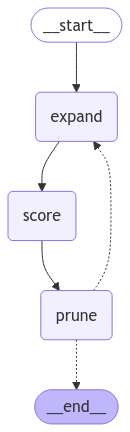

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Run

In [10]:
config = {
    "configurable": {
        "thread_id": "test_1",
        "depth": 10,
    }
}
for step in graph.stream({"problem": puzzles[42]}, config):
    print(step)

{'expand': {'candidates': [Candidate(candidate=Equation(tokens=[12.0, '*', 1.0, '+', 5.0, '+', 7.0]), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, '*', 1.0, '+', 5.0, '*', 7.0]), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, '*', 1.0, '*', 5.0, '+', 7.0]), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, '/', 1.0, '*', 5.0, '*', 7.0]), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, '*', 1.0, '+', 7.0, '*', 5.0]), score=None, feedback=None)]}}
{'score': {'candidates': 'clear', 'scored_candidates': [ScoredCandidate(candidate=Equation(tokens=[12.0, '*', 1.0, '+', 5.0, '+', 7.0]), score=0, feedback="Invalid equation. Error: IndexError('pop from empty list')"), ScoredCandidate(candidate=Equation(tokens=[12.0, '*', 1.0, '+', 5.0, '*', 7.0]), score=0, feedback="Invalid equation. Error: IndexError('pop from empty list')"), ScoredCandidate(candidate=Equation(tokens=[12.0, '*', 1.0, '*', 5.0, '+', 7.

In [11]:
final_state = graph.get_state(config)
winning_solution = final_state.values["candidates"][0]
search_depth = final_state.values["depth"]
if winning_solution[1] == 1:
    print(f"Found a winning solution in {search_depth} steps: {winning_solution}")
else:
    print(
        f"Failed to find a winning solution in {search_depth} steps. Best guess: {winning_solution}"
    )

Found a winning solution in 3 steps: [Equation(tokens=[12.0, 1.0, '/', 7.0, '+', 5.0, '+']), 1.0, 'Result: 24.0']
